##### Channel/Ranged Trading strategy 

[*********************100%***********************]  1 of 1 completed


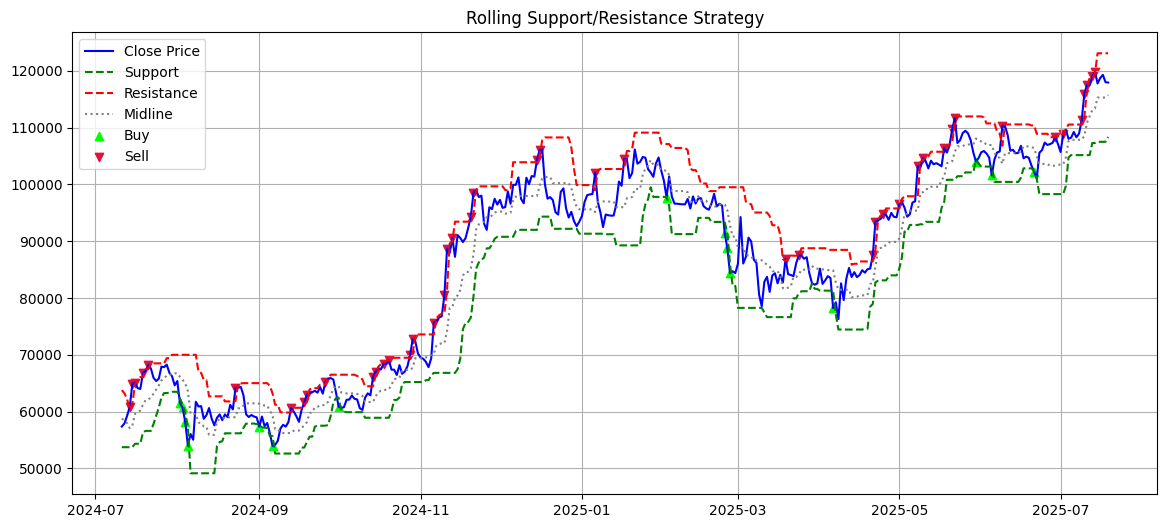

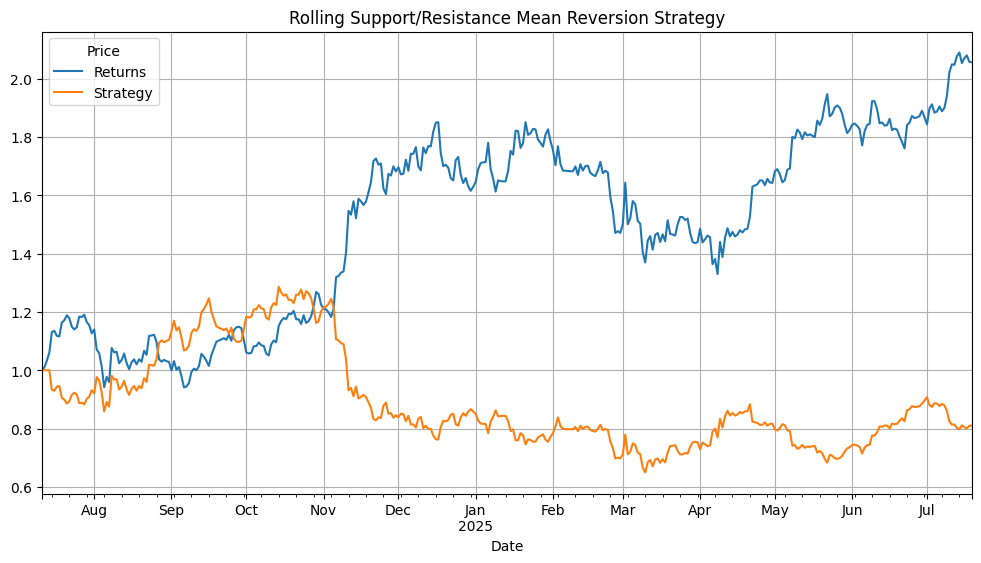

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# [ltc, btc, eth]

ticker = "BTC-USD"
start = "2024-07-01"
end = "2025-07-20"

def download_data(start, end, ticker):
    data = yf.download(ticker, start=start, end=end, interval="1d", auto_adjust=False)
    if data.empty:
        print("No data fetched. Check ticker, interval, or date range.")
        return pd.DataFrame()
    
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data



def compute_rolling_levels(data, window=20):
    data['Support'] = data['Low'].rolling(window).min().shift(1)
    data['Resistance'] = data['High'].rolling(window).max().shift(1)
    data['Mid'] = (data['Support'] + data['Resistance']) / 2
    return data


def generate_signals(data):
    data = data.copy()
    data = data.dropna(subset=['Support', 'Resistance'])

    # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
    data['Signal'] = 0
    data.loc[data['Close'] <= data['Support'], 'Signal'] = 1
    data.loc[data['Close'] >= data['Resistance'], 'Signal'] = -1

    # Exit: -1 to close long, +1 to close short
    data['Exit'] = 0
    data['Prev_Position'] = 0

    for i in range(1, len(data)):
        prev_pos = data.at[data.index[i-1], 'Signal'] if data.at[data.index[i-1], 'Signal'] != 0 else data.at[data.index[i-1], 'Prev_Position']
        data.at[data.index[i], 'Prev_Position'] = prev_pos

        if prev_pos == 1 and data['Close'].iloc[i] >= data['Resistance'].iloc[i]:
            data.at[data.index[i], 'Exit'] = -1  # Exit long at resistance
        elif prev_pos == -1 and data['Close'].iloc[i] <= data['Support'].iloc[i]:
            data.at[data.index[i], 'Exit'] = 1  # Exit short at support

    # Position tracking
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = -1
        elif data['Exit'].iloc[i] != 0:
            position = 0
        data.at[data.index[i], 'Position'] = position

    data.drop(columns=['Prev_Position'], inplace=True)
    return data


def backtest(data):
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    (1 + data[['Returns', 'Strategy']]).cumprod().plot(figsize=(12, 6), title='Rolling Support/Resistance Mean Reversion Strategy')
    plt.grid()
    plt.show()


def plot_signals(data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.plot(data['Mid'], label='Midline', linestyle=':', color='gray')

    # Buy/Sell markers
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='lime')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='crimson')

    plt.title("Rolling Support/Resistance Strategy")
    plt.legend()
    plt.grid()
    plt.show()


# Run the strategy
if __name__ == "__main__":
    df = download_data(start=start, end=end, ticker=ticker)
    df = compute_rolling_levels(df, window=10)
    df = generate_signals(df)
    plot_signals(df)
    backtest(df)


##### Creating Machine Learning Model from for trend direction

In [2]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy
Date,,,,,,,,,,,,,,
2024-07-11,57344.914062,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,0,0,0,0.000000,NaN
2024-07-12,57899.464844,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,0,0,0,0.009670,0.000000
2024-07-13,59231.953125,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,0,0,0,0.023014,0.000000
2024-07-14,60787.792969,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,-1,0,-1,0.026267,0.000000
2024-07-15,64870.152344,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,-1,0,-1,0.067158,-0.067158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,0,0,-1,-0.017293,0.017293
2025-07-16,118738.507812,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,0,0,-1,0.008162,-0.008162
2025-07-17,119289.843750,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,0,0,-1,0.004643,-0.004643


In [3]:
import numpy as np

df["returns_difference"] = df["Returns"].diff()
df["trend_direction"] = np.where(df["returns_difference"].shift(-1) > 0, 1, 0)


In [4]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy,returns_difference,trend_direction
Date,,,,,,,,,,,,,,,,
2024-07-11,57344.914062,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,0,0,0,0.000000,NaN,NaN,1
2024-07-12,57899.464844,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,0,0,0,0.009670,0.000000,0.009670,1
2024-07-13,59231.953125,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,0,0,0,0.023014,0.000000,0.013343,1
2024-07-14,60787.792969,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,-1,0,-1,0.026267,0.000000,0.003253,1
2024-07-15,64870.152344,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,-1,0,-1,0.067158,-0.067158,0.040891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,0,0,-1,-0.017293,0.017293,-0.023451,1
2025-07-16,118738.507812,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,0,0,-1,0.008162,-0.008162,0.025455,0
2025-07-17,119289.843750,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,0,0,-1,0.004643,-0.004643,-0.003519,0


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
X = df.iloc[:,1:6].to_numpy()
Y = df.iloc[:,-1].to_numpy()
X,Y

(array([[5.73449141e+04, 5.92994336e+04, 5.71203789e+04, 5.77298906e+04,
         2.87078038e+10],
        [5.78994648e+04, 5.85325547e+04, 5.65901758e+04, 5.73411953e+04,
         2.56048052e+10],
        [5.92319531e+04, 5.97870781e+04, 5.77964414e+04, 5.79087383e+04,
         1.70800618e+10],
        ...,
        [1.19289844e+05, 1.20999609e+05, 1.17508219e+05, 1.18738508e+05,
         7.23638418e+10],
        [1.18003227e+05, 1.20851914e+05, 1.16925984e+05, 1.19284109e+05,
         7.79457998e+10],
        [1.17939977e+05, 1.18541398e+05, 1.17388414e+05, 1.17998125e+05,
         4.75645628e+10]], shape=(374, 5)),
 array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
     

In [8]:
X.shape, Y.shape

((374, 5), (374,))

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [10]:
X_train

array([[1.05652102e+05, 1.05884547e+05, 1.03826953e+05, 1.04637297e+05,
        3.73970569e+10],
       [5.81270117e+04, 5.85343594e+04, 5.73301016e+04, 5.73431719e+04,
        3.38357079e+10],
       [1.06045633e+05, 1.06316828e+05, 1.04740242e+05, 1.05571516e+05,
        4.88229864e+10],
       ...,
       [1.03241461e+05, 1.03969539e+05, 9.69138750e+04, 9.70342500e+04,
        6.98954044e+10],
       [7.92353359e+04, 8.11190625e+04, 7.44366797e+04, 7.82213359e+04,
        9.12624250e+10],
       [5.60343164e+04, 5.70599180e+04, 5.39732734e+04, 5.39913477e+04,
        4.93004841e+10]], shape=(299, 5))

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
sc = StandardScaler()

In [13]:
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 1.06472644,  0.98896575,  1.0690745 ,  1.01627159, -0.34212089],
       [-1.56369712, -1.61010045, -1.5264291 , -1.59650149, -0.48298228],
       [ 1.08649108,  1.0126938 ,  1.12005527,  1.06788268,  0.10980683],
       ...,
       [ 0.9314035 ,  0.88385039,  0.68317914,  0.59623979,  0.94328035],
       [-0.39627972, -0.37041922, -0.57152175, -0.44308328,  1.78840624],
       [-1.67943577, -1.69103298, -1.71381081, -1.78167367,  0.1286932 ]],
      shape=(299, 5))

In [14]:
model = LogisticRegression()
model.fit(X_train,Y_train)

LogisticRegression()

In [15]:
Y_pred = model.predict(X_test)


In [16]:
Y_test

array([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1])

In [17]:
Y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0])

In [18]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.79


#### Integrating the model with the strategy

In [19]:
df["predicted_direction"] = model.predict(X)

In [20]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,Signal,Exit,Position,Returns,Strategy,returns_difference,trend_direction,predicted_direction
Date,,,,,,,,,,,,,,,,,
2024-07-11,57344.914062,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,0,0,0,0.000000,NaN,NaN,1,1
2024-07-12,57899.464844,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,0,0,0,0.009670,0.000000,0.009670,1,1
2024-07-13,59231.953125,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,0,0,0,0.023014,0.000000,0.013343,1,1
2024-07-14,60787.792969,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,-1,0,-1,0.026267,0.000000,0.003253,1,1
2024-07-15,64870.152344,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,-1,0,-1,0.067158,-0.067158,0.040891,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,0,0,-1,-0.017293,0.017293,-0.023451,1,1
2025-07-16,118738.507812,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,0,0,-1,0.008162,-0.008162,0.025455,0,1
2025-07-17,119289.843750,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,0,0,-1,0.004643,-0.004643,-0.003519,0,1


In [21]:
df.drop(columns=["Signal", "Exit", "Position", "Returns", "Strategy", "returns_difference", "trend_direction"], inplace=True)

In [22]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Support,Resistance,Mid,predicted_direction
Date,,,,,,,,,,
2024-07-11,57344.914062,57344.914062,59299.433594,57120.378906,57729.890625,28707803842,53717.375000,63777.226562,58747.300781,1
2024-07-12,57899.464844,57899.464844,58532.554688,56590.175781,57341.195312,25604805221,53717.375000,63203.359375,58460.367188,1
2024-07-13,59231.953125,59231.953125,59787.078125,57796.441406,57908.738281,17080061806,53717.375000,62187.703125,57952.539062,1
2024-07-14,60787.792969,60787.792969,61329.527344,59225.250000,59225.250000,22223416061,53717.375000,60399.675781,57058.525391,1
2024-07-15,64870.152344,64870.152344,64870.152344,60704.929688,60815.457031,38094526099,53717.375000,61329.527344,57523.451172,1
...,...,...,...,...,...,...,...,...,...,...
2025-07-15,117777.187500,117777.187500,119935.562500,115765.687500,119853.851562,98321661181,107499.554688,123091.609375,115295.582031,1
2025-07-16,118738.507812,118738.507812,120065.515625,117064.820312,117777.187500,72162029070,107499.554688,123091.609375,115295.582031,1
2025-07-17,119289.843750,119289.843750,120999.609375,117508.218750,118738.507812,72363841798,107499.554688,123091.609375,115295.582031,1


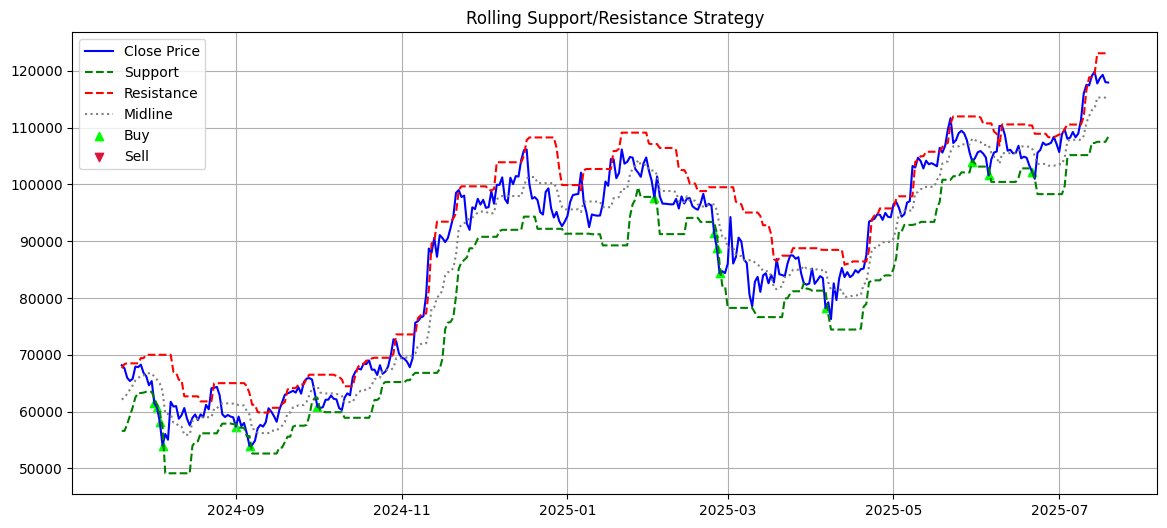

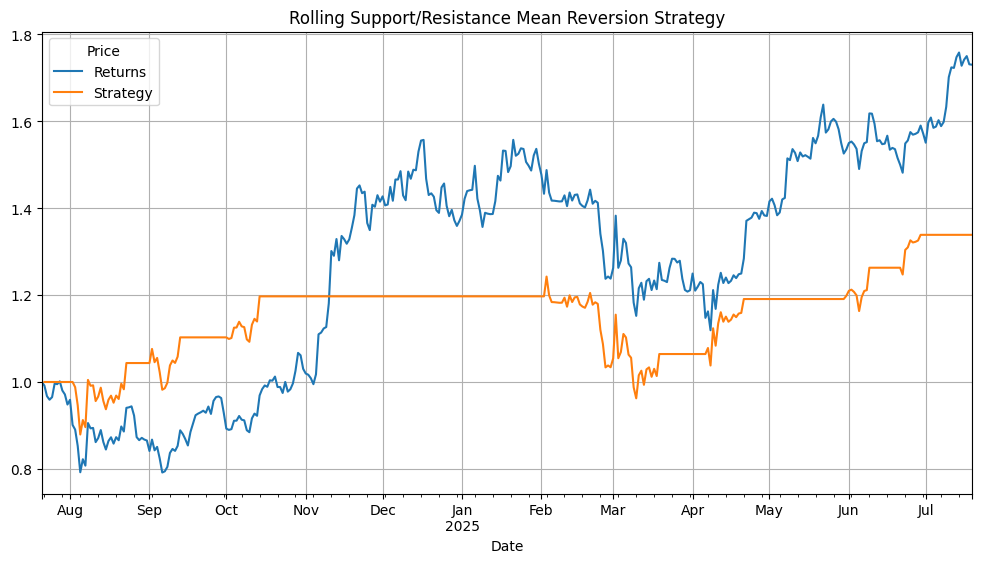

0.3472225150787731


In [23]:

def generate_signals(data):
    data = data.copy()
    data = data.dropna(subset=['Support', 'Resistance'])

    # Signal: 1 for Buy, -1 for Sell, 0 for Neutral
    data['Signal'] = 0

    # Long Entry Condition
    data.loc[
        (data['Close'] <= data['Support']) &
        (data['predicted_direction'] == 1),
        'Signal'
    ] = 1

    # Short Entry Condition
    data.loc[
        (data['Close'] >= data['Resistance']) &
        (data['predicted_direction'] == 0),
        'Signal'
    ] = -1

    # Exit logic
    data['Exit'] = 0
    data['Prev_Position'] = 0

    for i in range(1, len(data)):
        prev_pos = data.at[data.index[i-1], 'Signal'] if data.at[data.index[i-1], 'Signal'] != 0 else data.at[data.index[i-1], 'Prev_Position']
        data.at[data.index[i], 'Prev_Position'] = prev_pos

        if prev_pos == 1 and data['Close'].iloc[i] >= data['Resistance'].iloc[i]:
            data.at[data.index[i], 'Exit'] = -1  # Exit long at resistance
        elif prev_pos == -1 and data['Close'].iloc[i] <= data['Support'].iloc[i]:
            data.at[data.index[i], 'Exit'] = 1  # Exit short at support

    # Position tracking
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data['Signal'].iloc[i] == 1:
            position = 1
        elif data['Signal'].iloc[i] == -1:
            position = -1
        elif data['Exit'].iloc[i] != 0:
            position = 0
        data.at[data.index[i], 'Position'] = position

    data.drop(columns=['Prev_Position'], inplace=True)
    return data


def backtest(data):
    data['Returns'] = data['Close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    (1 + data[['Returns', 'Strategy']]).cumprod().plot(figsize=(12, 6), title='Rolling Support/Resistance Mean Reversion Strategy')
    plt.grid()
    plt.show()


def plot_signals(data):
    plt.figure(figsize=(14, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.plot(data['Mid'], label='Midline', linestyle=':', color='gray')

    # Buy/Sell markers
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='lime')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='crimson')

    plt.title("Rolling Support/Resistance Strategy")
    plt.legend()
    plt.grid()
    plt.show()


# Run the strategy
if __name__ == "__main__":
    df = compute_rolling_levels(df, window=10)
    df = generate_signals(df)
    plot_signals(df)
    backtest(df)
    print(df["Strategy"].sum())